In [6]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from ase.io import read
import ase
import time 
from tqdm.notebook import tqdm
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from rascal.representations import SphericalExpansion, SphericalInvariants
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from rascal.utils import radial_basis
from rascal.utils import (WignerDReal, ClebschGordanReal, 
                          spherical_expansion_reshape, spherical_expansion_conjugate,
                    lm_slice, real2complex_matrix, compute_lambda_soap)
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species,mask_center_atoms_by_id

In [8]:
from skcosmo.linear_model import AtomRidge
from skcosmo.model_selection import atom_groups_by_frame, train_test_split_by_frame

In [9]:
#AtomRidge is for loss implementation as dicsussed on 11th of november

# do not split by environment split by structure -+ symmetries in crystal structures 
# can lead to equal environments 

# 

In [10]:
frames = read("./make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz","::20")
clean_frames = []
for f in frames:
    if f.info['STATUS'] == 'PASSING':
        clean_frames.append(f)
    else:
        print(f.info['NAME'], f.info['STATUS'])
frames = clean_frames

ORAVUZ SUSPICIOUS
SAJYEH SUSPICIOUS
DIZVOZ SUSPICIOUS
CUGLUN SUSPICIOUS


In [11]:
y = []
s = []
atom_sigma = {'H': 0.1, 'C': 1, 'N':1, 'O':1, 'S':2}
type_idx = {'H': [], 'C': [], 'N': [], 'O': [], 'S': []}
idx = 0
groups = []
for iframe, f in enumerate(frames):
    y.append(f.arrays['cs_iso'])
    f.wrap(eps=1e-12)
    for l in f.symbols:
        type_idx[l].append(idx)
        idx+=1
        s.append(atom_sigma[l])    
groups = atom_groups_by_frame(frames)        
cs = np.concatenate(y)
sigmas = np.asarray(s)

In [14]:
f.info

{'magres_units': {'cs_tensor': 'ppm', 'cs_iso': 'ppm'},
 'STATUS': 'PASSING',
 'NAME': 'FADBOB',
 'ENERGY': -2300.05217586}

In [13]:
hypers_1 = {
    'interaction_cutoff': 6,
    'max_radial': 10,
    'max_angular': 0,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.2,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'DVR',        
    'soap_type' : "RadialSpectrum",
    'normalize' : False
}

hypers_2 = {
    'interaction_cutoff': 6,
    'max_radial': 8,
    'max_angular': 6,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.2,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'DVR',
    'normalize' : False,
    'soap_type' : "PowerSpectrum"
}

hypers_1 = get_optimal_radial_basis_hypers(hypers_1, frames, expanded_max_radial=50)
hypers_2 = get_optimal_radial_basis_hypers(hypers_2, frames, expanded_max_radial=50)

KeyboardInterrupt: 

In [ ]:
soap1 = SphericalInvariants(**hypers_1)
soap2 = SphericalInvariants(**hypers_2)

In [ ]:
feat1 = soap1.transform(frames).get_features(soap1)
feat2 = soap2.transform(frames).get_features(soap2)

In [ ]:
feat1.shape

In [ ]:
from sklearn.model_selection import GroupKFold, GridSearchCV, train_test_split

In [ ]:
#from skcosmo.kernel_model import RKHSTransform
from skcosmo.sample_selection import CUR, PCovCUR, FPS

In [17]:
feats = np.hstack([feat1, feat2])
X_train, X_test, y_train, y_test, sig_train, sig_test, g_train, g_test = train_test_split_by_frame(frames, feats, cs, sigmas, train_size=0.8)

In [18]:
ar = AtomRidge(sigma=1, delta=[10, 2], feature_groups=[slice(0,feat1.shape[1]), slice(feat1.shape[1],feat1.shape[1]+feat2.shape[1])])

In [19]:
splits = list(GroupKFold(n_splits=2).split(X_train, y_train, g_train))
gcv = GridSearchCV(ar, dict(delta=[[1,100], [1,10], [1, 1], [10, 1], [100,1]]), cv = splits, scoring='neg_mean_squared_error')

In [20]:
ar.fit(X_train, y_train, sample_sigmas=sig_train)

In [21]:
gcv.fit(X_train, y_train, sample_sigmas=sig_train)

GridSearchCV(cv=[(array([   48,    49,    50, ..., 12388, 12389, 12390]),
                  array([    0,     1,     2, ..., 12516, 12517, 12518])),
                 (array([    0,     1,     2, ..., 12516, 12517, 12518]),
                  array([   48,    49,    50, ..., 12388, 12389, 12390]))],
             estimator=AtomRidge(delta=[10, 2],
                                 feature_groups=[slice(0, 50, None),
                                                 slice(50, 6770, None)],
                                 sigma=1),
             param_grid={'delta': [[1, 100], [1, 10], [1, 1], [10, 1],
                                   [100, 1]]},
             scoring='neg_mean_squared_error')

In [22]:
gcv.cv_results_

{'mean_fit_time': array([9.77995157, 8.71252716, 8.86782694, 8.19846475, 8.09635651]),
 'std_fit_time': array([0.12617469, 0.62481511, 0.02244496, 0.27919543, 0.22832644]),
 'mean_score_time': array([0.89520335, 0.79375887, 0.81087995, 0.75069821, 0.73616409]),
 'std_score_time': array([0.03439927, 0.02039814, 0.01566386, 0.14561546, 0.06710982]),
 'param_delta': masked_array(data=[list([1, 100]), list([1, 10]), list([1, 1]),
                    list([10, 1]), list([100, 1])],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'delta': [1, 100]},
  {'delta': [1, 10]},
  {'delta': [1, 1]},
  {'delta': [10, 1]},
  {'delta': [100, 1]}],
 'split0_test_score': array([-2586.47216441, -2089.35336834, -1821.57109327, -1804.70164913,
        -1806.46648514]),
 'split1_test_score': array([-2935.61359181, -2696.64796999, -2332.56827662, -2206.94776095,
        -2205.86307688]),
 'mean_test_score': array([-2761.04287811, -2393.0

In [23]:
cs_pred = gcv.predict(feats)

In [24]:
p_test = gcv.predict(X_test)

34.38657195325989

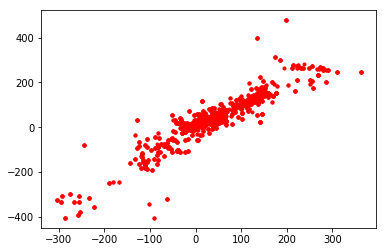

In [25]:
plt.plot(p_test, y_test, 'r.')
np.sqrt(np.mean((p_test-y_test)**2))

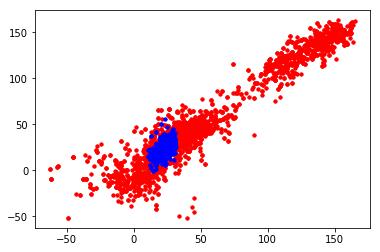

In [26]:
plt.plot(cs[type_idx['C']], cs_pred[type_idx['C']], 'r.')
plt.plot(cs[type_idx['H']], cs_pred[type_idx['H']], 'b.')

In [27]:
sel = FPS(n_to_select = 1000, progress_bar=tqdm)

In [23]:
sel.fit(feats)

FPS()

In [24]:
KBB1 = (feat1[sel.selected_idx_]@feat1[sel.selected_idx_].T)**2
KBB2 = (feat2[sel.selected_idx_]@feat2[sel.selected_idx_].T)**2

In [25]:
rkhs1 = RKHSTransform(jitter=1e-10)
rkhs1.fit(KBB1)
rkhs2 = RKHSTransform(jitter=1e-10)
rkhs2.fit(KBB2)

In [26]:
feats = np.hstack([rkhs1.transform((feat1@feat1[sel.selected_idx_].T)**2), 
                   rkhs2.transform((feat2@feat2[sel.selected_idx_].T)**2)])
X_train, X_test, y_train, y_test, sig_train, sig_test, g_train, g_test = train_test_split_by_frame(frames, feats, cs, sigmas, train_size=0.8)

In [27]:
ar = AtomRidge(sigma=1, delta=[10, 2], feature_groups=[slice(0,rkhs1.nB_), slice(rkhs1.nB_,rkhs1.nB_+rkhs2.nB_)])
splits = list(GroupKFold(n_splits=2).split(X_train, y_train, g_train))
gcv = GridSearchCV(ar, dict(delta=[[1,100], [1,10], [1, 1], [10, 1], [100,1]]), cv = splits, scoring='neg_mean_squared_error')

In [28]:
gcv.fit(X_train, y_train, sample_sigmas=sig_train)

GridSearchCV(cv=[(array([   48,    49,    50, ..., 12806, 12807, 12808]),
                  array([    0,     1,     2, ..., 12658, 12659, 12660])),
                 (array([    0,     1,     2, ..., 12658, 12659, 12660]),
                  array([   48,    49,    50, ..., 12806, 12807, 12808]))],
             estimator=AtomRidge(delta=[10, 2],
                                 feature_groups=[slice(0, 961, None),
                                                 slice(961, 1961, None)],
                                 sigma=1),
             param_grid={'delta': [[1, 100], [1, 10], [1, 1], [10, 1],
                                   [100, 1]]},
             scoring='neg_mean_squared_error')

In [29]:
gcv.cv_results_

{'mean_fit_time': array([0.57306707, 0.56071413, 0.57852292, 0.59785664, 0.66454113]),
 'std_fit_time': array([0.00267851, 0.00508988, 0.00524592, 0.00488198, 0.05927074]),
 'mean_score_time': array([0.08969927, 0.08821619, 0.09062922, 0.09227931, 0.10231376]),
 'std_score_time': array([2.85792351e-03, 5.90682030e-04, 4.64916229e-06, 3.19838524e-04,
        2.43973732e-03]),
 'param_delta': masked_array(data=[list([1, 100]), list([1, 10]), list([1, 1]),
                    list([10, 1]), list([100, 1])],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'delta': [1, 100]},
  {'delta': [1, 10]},
  {'delta': [1, 1]},
  {'delta': [10, 1]},
  {'delta': [100, 1]}],
 'split0_test_score': array([-6871.25681638, -4275.81785461, -2327.1206239 , -2435.99582069,
        -3313.62749191]),
 'split1_test_score': array([-8311.50051452, -4682.43061987, -1994.2089419 , -2013.5957211 ,
        -3163.56645951]),
 'mean_test_score': ar

In [5]:
cs_pred = gcv.predict(feats)

NameError: name 'gcv' is not defined

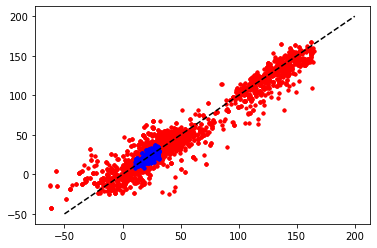

In [31]:
plt.plot(cs[type_idx['C']], cs_pred[type_idx['C']], 'r.')
plt.plot(cs[type_idx['H']], cs_pred[type_idx['H']], 'b.')
plt.plot([-50,200],[-50,200], 'k--')

In [32]:
p_test = gcv.predict(X_test)

37.9234057386919

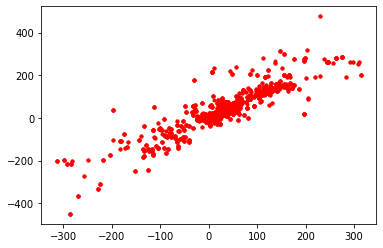

In [33]:
plt.plot(p_test, y_test, 'r.')
np.sqrt(np.mean((p_test-y_test)**2))

In [34]:
feats = np.hstack([feat1, feat2, rkhs1.transform((feat1@feat1[sel.selected_idx_].T)**2), 
                   rkhs2.transform((feat2@feat2[sel.selected_idx_].T)**2)])
ar = AtomRidge(sigma=1, delta=[10, 2], 
               feature_groups=[slice(0,feat1.shape[1]),
                               slice(feat1.shape[1],feat1.shape[1]+feat2.shape[1]),
                               slice(feat1.shape[1]+feat2.shape[1],feat1.shape[1]+feat2.shape[1]+rkhs1.nB_),
                               slice(feat1.shape[1]+feat2.shape[1]+rkhs1.nB_,
                                     feat1.shape[1]+feat2.shape[1]+rkhs1.nB_+rkhs2.nB_)])
X_train, X_test, y_train, y_test, sig_train, sig_test, g_train, g_test = train_test_split_by_frame(frames, feats, cs, sigmas, train_size=0.8)

In [35]:
splits = list(GroupKFold(n_splits=2).split(X_train, y_train, g_train))
gcv = GridSearchCV(ar, dict(delta=[[1,1,1,1], [10,1,1,1], [1, 10, 1, 1], [1, 1, 1,10]]), cv = splits, scoring='neg_mean_squared_error')

In [36]:
gcv.fit(X_train, y_train, sample_sigmas=sig_train)

GridSearchCV(cv=[(array([    0,     1,     2, ..., 12873, 12874, 12875]),
                  array([   86,    87,    88, ..., 12605, 12606, 12607])),
                 (array([   86,    87,    88, ..., 12605, 12606, 12607]),
                  array([    0,     1,     2, ..., 12873, 12874, 12875]))],
             estimator=AtomRidge(delta=[10, 2],
                                 feature_groups=[slice(0, 50, None),
                                                 slice(50, 6770, None),
                                                 slice(6770, 7731, None),
                                                 slice(7731, 8731, None)],
                                 sigma=1),
             param_grid={'delta': [[1, 1, 1, 1], [10, 1, 1, 1], [1, 10, 1, 1],
                                   [1, 1, 1, 10]]},
             scoring='neg_mean_squared_error')

In [37]:
gcv.cv_results_

{'mean_fit_time': array([ 9.85993683, 13.27722335, 12.66051674, 11.67009723]),
 'std_fit_time': array([1.35135758, 1.50251627, 0.07989526, 0.10312021]),
 'mean_score_time': array([1.03893089, 1.13393652, 1.11975455, 0.98259676]),
 'std_score_time': array([0.07027054, 0.11650789, 0.00368428, 0.00716817]),
 'param_delta': masked_array(data=[list([1, 1, 1, 1]), list([10, 1, 1, 1]),
                    list([1, 10, 1, 1]), list([1, 1, 1, 10])],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'delta': [1, 1, 1, 1]},
  {'delta': [10, 1, 1, 1]},
  {'delta': [1, 10, 1, 1]},
  {'delta': [1, 1, 1, 10]}],
 'split0_test_score': array([-2254.38191997, -2350.89008397, -2407.5595815 , -4178.02238631]),
 'split1_test_score': array([-1904.86760492, -1755.33312981, -2329.76061556, -5183.96133146]),
 'mean_test_score': array([-2079.62476245, -2053.11160689, -2368.66009853, -4680.99185888]),
 'std_test_score': array([174.75715753, 297.77847

In [53]:
cs_pred = gcv.predict(feats)

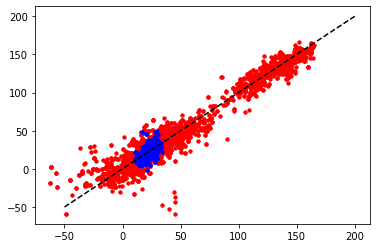

In [54]:
plt.plot(cs[type_idx['C']], cs_pred[type_idx['C']], 'r.')
plt.plot(cs[type_idx['H']], cs_pred[type_idx['H']], 'b.')
plt.plot([-50,200],[-50,200], 'k--')

In [55]:
p_test = gcv.predict(X_test)

33.52512284197961

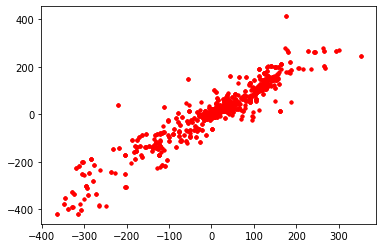

In [56]:
plt.plot(p_test, y_test, 'r.')
np.sqrt(np.mean((p_test-y_test)**2))